# <center>DataLab Cup 4: Recommender Systems</center>
<center>Shan-Hung Wu & DataLab</center>
<center>Fall 2023</center>

## Platform: [Kaggle](https://www.kaggle.com/t/b06e248a3827434f80c4fdc6009d5fe0)

Please download the dataset and the environment source code from Kaggle.

## Overview

In this competition, your goal is to design a recommender system that suggests news articles to users. The performance of your recommender system will be assessed using a simulation environment.

At each timestep, the simulation environment randomly selects an active user with a given `user_id`. Once you receive this `user_id`, your recommender system must generate a slate **(a list of 5 distinct `item_ids` to recommend to the current user)** and pass it to the environment. The environment then uses its internal information to determine which item the user will choose from the recommended list (with some degree of stochasticity) or decide not to choose any item due to a lack of interest.

Each user has a latent patience value (invisible to your recommender system), which slightly increases when an item is chosen and drastically decreases when no item is chosen in each round. If a user's patience drops below 0 or the user runs out of the time budget (2000 timesteps), the user leaves the environment. The chosen `item_id` (or `-1` if no item is chosen) and whether the current user stays (`True`) or leaves (`False`) are returned as the result of recommending a slate of items. A new user (if any) will be randomly selected for recommendations in the next timestep after the response of the current user is generated.

Your recommender system should continue recommending items to the current user at each timestep as long as there are still active users in the environment. The simulation process terminates after all users have left the system.

**Your goal is to maximize the session length of each user.** The session length is defined as the number of timesteps a user interacts with your recommender system before leaving the environment. The calculated session length score, normalized to the range of 0 ~ 1, will be provided by the simulation environment after the completion of the simulation process.

In [1]:
import os
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

from evaluation.environment import TrainingEnvironment, TestingEnvironment

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Official hyperparameters for this competition (do not modify)
N_TRAIN_USERS = 1000
N_TEST_USERS = 2000
N_ITEMS = 209527
HORIZON = 2000
TEST_EPISODES = 5
SLATE_SIZE = 5

## Datasets

In this competition, we won't provide a substantial user-item interaction dataset. Instead, limited information (3 items per user) on historical interactions will be available. To train your recommender system effectively, you need to employ a recommender policy to interact with the training environment and collect additional interaction data.

We will introduce the side-information datasets provided in the following sections.

In [3]:
# Dataset paths
USER_DATA = os.path.join('dataset', 'user_data.json')
ITEM_DATA = os.path.join('dataset', 'item_data.json')

# Output file path
OUTPUT_PATH = os.path.join('output', 'output.csv')

## User Data

In the **training environment**, there are a total of **1000 users** identified by IDs ranging from 0 to 999. For the **testing environment**, there are **2000 users** with IDs ranging from 0 to 1999. The **testing environment includes the same 1000 users found in the training environment** (user 0 to user 999), and an additional 1000 new users (user 1000 to user 1999) are introduced.

For all 2000 users, we provide you with the **past 3 clicked item IDs of each user**. Let's examine the user dataset.

In [4]:
df_user = pd.read_json(USER_DATA, lines=True)
df_user

,user_id,history
0,0,"[42558, 65272, 13353]"
1,1,"[146057, 195688, 143652]"
2,2,"[67551, 85247, 33714]"
3,3,"[116097, 192703, 103229]"
4,4,"[68756, 140123, 135289]"
...,...,...
1995,1995,"[95090, 131393, 130239]"
1996,1996,"[2360, 147130, 8145]"
1997,1997,"[99794, 138694, 157888]"
1998,1998,"[55561, 60372, 51442]"


In [5]:
# 使用 explode 將 history 列展開為多行
df_clicked = df_user.explode('history')

# 將點擊過的新欄位設為1
df_clicked['clicked'] = 1

# 重新設置索引
df_clicked.reset_index(drop=True, inplace=True)

df_clicked['user_id'] = df_clicked['user_id'].astype(int)
df_clicked['history'] = df_clicked['history'].astype(int)
df_clicked['clicked'] = df_clicked['clicked'].astype(int)

# 顯示處理後的 DataFrame
print(df_clicked)

      user_id  history  clicked
0           0    42558        1
1           0    65272        1
2           0    13353        1
3           1   146057        1
4           1   195688        1
...       ...      ...      ...
5995     1998    60372        1
5996     1998    51442        1
5997     1999   125409        1
5998     1999    77906        1
5999     1999   124792        1

[6000 rows x 3 columns]


## Item Data

Both the training and testing environments share a common pool of **209527 items** as their item candidate pool. For the side information of these items, we provide text descriptions for each news article. The item dataset is derived from the [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset). It's important to note that you should only use the dataset provided by us. Utilizing the original dataset, which contains extra information, will be considered as cheating. Let's explore the item dataset.

In [6]:
df_item = pd.read_json(ITEM_DATA, lines=True)
df_item

,item_id,headline,short_description
0,0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...
1,1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...
2,2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha..."
3,3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to..."
4,4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...
...,...,...,...
209522,209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...
209523,209523,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr..."
209524,209524,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked..."
209525,209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...


## Simulation Environments

We offer two simulation environments in this competition: `TrainingEnvironment` and `TestingEnvironment`. The only distinction between the two environments is the number of users, with 1000 for training and 2000 for testing. All public methods for both environments behave the same since they share the same base class.

**Important Note: Ensure that you collect interaction data only by accessing the environment through the designated public methods listed below. Directly accessing or modifying any file or code in the `evaluation` directory, or retrieving internal attributes and states of the environment (including all attributes / methods starting with an underscore `_`), will be considered as cheating.**

## Environment Classes

### <kbd>class</kbd> `TrainingEnvironment`
Class for the training environment. Contains first 1000 users with user ID ranging from 0 to 999. 

### <kbd>class</kbd> `TestingEnvironment`
Class for the testing environment. Contains all 2000 users with user ID ranging from 0 to 1999. 

## Environment Public Methods

**Note that both `TrainingEnvironment` and `TestingEnvironment` shares the same set of public methods.**

---

### <kbd>function</kbd> `reset`


```python
reset() → None
```

<br/>
Reset the environment to its initial parameters and states. 

---

### <kbd>function</kbd> `has_next_state`


```python
has_next_state() → bool
```

<br/>
Verify whether the next state exists. The next state is considered to exist if there is at least one user still present in the environment. 

**Returns:**

  - `True` if the next state exists, `False` otherwise. 

---

### <kbd>function</kbd> `get_state`


```python
get_state() → int
```

<br/>
Get the current state (the user ID of the current user). 

**Returns:**
 
 - <b>``int``</b>:  The user ID of the current user, or `-1` if there are no active users in the environment. 

---

### <kbd>function</kbd> `get_response`


```python
get_response(slate: list) → tuple[int, bool]
```

<br/>
Send the recommended slate (list of 5 distinct item IDs) and get the response from the current user. The internal user state will be updated according to the response, and a random user will be selected to be the next user (next state). 

**Args:**
 
 - <b>`slate`</b>:  `list[int]`  A list of 5 distinct item IDs to be recommended. 

**Returns:**

 - <b>`tuple[int, bool]`</b>:  The first entry indicates the `item ID` chosen by the user, or `-1` if the user decides not to choose any item.  The second entry represents whether the user is still in the environment after this interaction round. `True` if the user stays, `False` if the user leaves. 

**Raises:**
 
 - <b>``AssertionError``</b>:  If the slate length is not 5, contains duplicates or out-of-range item IDs, or if there are no active users in the environment. 

---

### <kbd>function</kbd> `get_score`


```python
get_score() → list[float]
```

<br/>
Get the normalized session length score (0 ~ 1) for each user. 

**Returns:**
 
 - <b>``list[float]``</b>:  A list containing the normalized session length score for each user. 

## Training

The implementation of the recommender algorithm is left to you. If you're in need of ideas, you can refer to the [Recommender Systems Tutorial](https://nthu-datalab.github.io/ml/labs/recommender-systems-tutorial/recommender-systems-tutorial.html) notebook in Lecture 16. Here, we'll just provide some example use cases of the public methods.

**Hint:** If you're looking for inspiration, consider starting by collecting interaction data from the environment using your initial recommender policy. Afterward, improve your model with this data, and iterate through this collect-then-train loop.

**Important Note: Ensure that you save your model weights after training. You will need to load a set of model weights trained exclusively on the training environment at the beginning of each test episode.**

In [7]:
# Get bias_mu
BIAS_MU = df_clicked['clicked'].mean()
print('bias_mu = ', BIAS_MU)

bias_mu =  1.0


In [8]:
class FunkSVDRecommender(tf.keras.Model):
    '''
    Simplified Funk-SVD recommender model
    '''

    def __init__(self, m_users: int, n_items: int, bias_mu, embedding_size: int, learning_rate: float,
                 regularization_train: bool, regularization_update: bool, seed: int):
        '''
        Constructor of the model
        '''
        super().__init__()
        self.m = m_users
        self.n = n_items
        self.k = embedding_size
        self.lr = learning_rate
        self.reg_train = regularization_train
        self.reg_update = regularization_update
        self.seed = seed
        self.B_mu = tf.constant([bias_mu])

        # user embeddings P
        self.P = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.m, self.k)))

        # item embeddings Q
        self.Q = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.n, self.k)))
        
        # bias term
        self.B_user = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.m, 1)))
        self.B_item = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.n, 1)))

        # optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.lr)

    @tf.function
    def call(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids), axis=1)
        
        y_pred = tf.add(y_pred, tf.squeeze(tf.gather(self.B_user, indices=user_ids)))
        y_pred = tf.add(y_pred, tf.squeeze(tf.gather(self.B_item, indices=item_ids)))

        return y_pred

    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor, regularization: bool) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        # loss = tf.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
        
        if regularization:
            loss = tf.losses.mean_squared_error(y_true, y_pred)
            reg = 0.01 * (tf.nn.l2_loss(self.Q) + tf.nn.l2_loss(self.P) +
                          tf.nn.l2_loss(self.B_item) + tf.nn.l2_loss(self.B_user))
            loss += reg
        else:
            loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function
    def train_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Train the model with one batch
        data: batched user-item interactions
        each record in data is in the format [user_id, history, clicked]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:
            y_pred = self(user_ids, item_ids)
            loss = self.compute_loss(y_true, y_pred, self.reg_train)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    @tf.function
    def eval_predict_onestep(self, user_id: int) -> tf.Tensor:
        '''
        Retrieve and return the NewsIDs of the 5 recommended news given a query
        You should return a tf.Tensor with shape=(5,)
        '''
        user_id = tf.cast(user_id, tf.int32)
        
        # dot product the selected user and all item embeddings to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, user_id) * self.Q, axis=1)
        
        y_pred = tf.add(tf.gather(self.B_user, user_id), y_pred)
        y_pred = tf.add(tf.squeeze(self.B_item), y_pred)

        # select the top 5 items with highest scores in y_pred
        y_top_5 = tf.math.top_k(y_pred, k=5).indices

        return y_top_5

In [9]:
@tf.function
def log2(x: tf.Tensor) -> tf.Tensor:
    return tf.math.log(tf.cast(x, tf.float32)) / tf.math.log(2.)

@tf.function
def ndcg_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return 1. / log2(2 + tf.argmax(idx))
    else:
        return tf.constant(0.)

@tf.function
def recall_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return tf.constant(1.)
    else:
        return tf.constant(0.)

def evaluate(model: tf.keras.Model, dataset: tf.data.Dataset) -> tuple:
    '''
    For each data point in the dataset:
    data[0] is the UserID
    data[1] is the NewsID 
    data[2] is the Clicked
    '''
    ndcg_scores = []
    recall_scores = []

    for data in tqdm(dataset, desc='Evaluating'):
        # query the model to make predictions if the observed event is a positive interaction (ratings >= 4)
        if data[2] == 1:
            y_pred = model.eval_predict_onestep(tf.gather(data, (0, 2)))
            y_true = tf.gather(data, 1)
            ndcg = ndcg_at_10(y_true, y_pred)
            recall = recall_at_10(y_true, y_pred)
            ndcg_scores.append(ndcg)
            recall_scores.append(recall)

    ndcg_result = tf.reduce_mean(ndcg_scores).numpy()
    recall_result = tf.reduce_mean(recall_scores).numpy()

    return ndcg_result, recall_result

In [10]:
# hyperparameters
EMBEDDING_SIZE = 256
BATCH_SIZE = 512
N_EPOCHS = 200
LEARNING_RATE = 1e-4
SEED = 0

# bad result if adding regularization
REGULARIZATION_TRAIN = False
REGULARIZATION_UPDATE = False

Epoch 1:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.13it/s]


Epoch 1 train_loss: 1.0082

Epoch 2:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.96it/s]


Epoch 2 train_loss: 0.9951

Epoch 3:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.19it/s]


Epoch 3 train_loss: 0.9830

Epoch 4:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.59it/s]


Epoch 4 train_loss: 0.9711

Epoch 5:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.65it/s]


Epoch 5 train_loss: 0.9592

Epoch 6:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 6 train_loss: 0.9474

Epoch 7:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.29it/s]


Epoch 7 train_loss: 0.9356

Epoch 8:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.61it/s]


Epoch 8 train_loss: 0.9239

Epoch 9:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.03it/s]


Epoch 9 train_loss: 0.9123

Epoch 10:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.48it/s]


Epoch 10 train_loss: 0.9007

Epoch 11:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.29it/s]


Epoch 11 train_loss: 0.8892

Epoch 12:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.43it/s]


Epoch 12 train_loss: 0.8777

Epoch 13:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.95it/s]


Epoch 13 train_loss: 0.8663

Epoch 14:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.65it/s]


Epoch 14 train_loss: 0.8550

Epoch 15:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.79it/s]


Epoch 15 train_loss: 0.8437

Epoch 16:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.32it/s]


Epoch 16 train_loss: 0.8324

Epoch 17:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.05it/s]


Epoch 17 train_loss: 0.8212

Epoch 18:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.24it/s]


Epoch 18 train_loss: 0.8101

Epoch 19:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.30it/s]


Epoch 19 train_loss: 0.7990

Epoch 20:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.48it/s]


Epoch 20 train_loss: 0.7879

Epoch 21:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.82it/s]

Epoch 21 train_loss: 0.7769

Epoch 22:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.42it/s]


Epoch 22 train_loss: 0.7659

Epoch 23:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.07it/s]


Epoch 23 train_loss: 0.7550

Epoch 24:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.31it/s]


Epoch 24 train_loss: 0.7441

Epoch 25:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.19it/s]


Epoch 25 train_loss: 0.7332

Epoch 26:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.21it/s]


Epoch 26 train_loss: 0.7224

Epoch 27:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.69it/s]


Epoch 27 train_loss: 0.7116

Epoch 28:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.02it/s]


Epoch 28 train_loss: 0.7009

Epoch 29:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.89it/s]


Epoch 29 train_loss: 0.6902

Epoch 30:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 30 train_loss: 0.6795

Epoch 31:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.16it/s]


Epoch 31 train_loss: 0.6689

Epoch 32:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.78it/s]


Epoch 32 train_loss: 0.6583

Epoch 33:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.82it/s]


Epoch 33 train_loss: 0.6478

Epoch 34:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.41it/s]


Epoch 34 train_loss: 0.6373

Epoch 35:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.53it/s]


Epoch 35 train_loss: 0.6268

Epoch 36:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.10it/s]


Epoch 36 train_loss: 0.6164

Epoch 37:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.38it/s]


Epoch 37 train_loss: 0.6061

Epoch 38:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.11it/s]


Epoch 38 train_loss: 0.5957

Epoch 39:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.88it/s]


Epoch 39 train_loss: 0.5854

Epoch 40:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.69it/s]


Epoch 40 train_loss: 0.5752

Epoch 41:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.37it/s]

Epoch 41 train_loss: 0.5650



Epoch 42:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.46it/s]


Epoch 42 train_loss: 0.5549

Epoch 43:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.60it/s]


Epoch 43 train_loss: 0.5448

Epoch 44:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.78it/s]


Epoch 44 train_loss: 0.5348

Epoch 45:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.89it/s]


Epoch 45 train_loss: 0.5248

Epoch 46:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.21it/s]


Epoch 46 train_loss: 0.5149

Epoch 47:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.04it/s]


Epoch 47 train_loss: 0.5050

Epoch 48:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.87it/s]


Epoch 48 train_loss: 0.4952

Epoch 49:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.98it/s]


Epoch 49 train_loss: 0.4855

Epoch 50:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.96it/s]


Epoch 50 train_loss: 0.4758

Epoch 51:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.44it/s]


Epoch 51 train_loss: 0.4662

Epoch 52:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.41it/s]


Epoch 52 train_loss: 0.4567

Epoch 53:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.14it/s]


Epoch 53 train_loss: 0.4472

Epoch 54:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.62it/s]


Epoch 54 train_loss: 0.4378

Epoch 55:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.65it/s]


Epoch 55 train_loss: 0.4285

Epoch 56:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.67it/s]


Epoch 56 train_loss: 0.4192

Epoch 57:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.92it/s]


Epoch 57 train_loss: 0.4101

Epoch 58:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.91it/s]


Epoch 58 train_loss: 0.4010

Epoch 59:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.42it/s]


Epoch 59 train_loss: 0.3920

Epoch 60:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.13it/s]


Epoch 60 train_loss: 0.3830

Epoch 61:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.87it/s]

Epoch 61 train_loss: 0.3742

Epoch 62:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.75it/s]


Epoch 62 train_loss: 0.3654

Epoch 63:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.50it/s]


Epoch 63 train_loss: 0.3568

Epoch 64:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.77it/s]


Epoch 64 train_loss: 0.3482

Epoch 65:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.85it/s]


Epoch 65 train_loss: 0.3397

Epoch 66:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.18it/s]


Epoch 66 train_loss: 0.3313

Epoch 67:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.31it/s]


Epoch 67 train_loss: 0.3230

Epoch 68:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.80it/s]


Epoch 68 train_loss: 0.3148

Epoch 69:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.80it/s]


Epoch 69 train_loss: 0.3068

Epoch 70:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.14it/s]


Epoch 70 train_loss: 0.2988

Epoch 71:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.22it/s]


Epoch 71 train_loss: 0.2909

Epoch 72:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 72 train_loss: 0.2831

Epoch 73:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.22it/s]


Epoch 73 train_loss: 0.2754

Epoch 74:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.29it/s]


Epoch 74 train_loss: 0.2679

Epoch 75:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.78it/s]


Epoch 75 train_loss: 0.2604

Epoch 76:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.72it/s]


Epoch 76 train_loss: 0.2531

Epoch 77:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.17it/s]


Epoch 77 train_loss: 0.2458

Epoch 78:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.98it/s]


Epoch 78 train_loss: 0.2387

Epoch 79:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.94it/s]


Epoch 79 train_loss: 0.2317

Epoch 80:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.22it/s]


Epoch 80 train_loss: 0.2248

Epoch 81:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.05it/s]

Epoch 81 train_loss: 0.2181

Epoch 82:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.58it/s]


Epoch 82 train_loss: 0.2114

Epoch 83:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.08it/s]


Epoch 83 train_loss: 0.2049

Epoch 84:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 84 train_loss: 0.1985

Epoch 85:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.85it/s]


Epoch 85 train_loss: 0.1922

Epoch 86:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.57it/s]


Epoch 86 train_loss: 0.1860

Epoch 87:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.21it/s]


Epoch 87 train_loss: 0.1799

Epoch 88:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.51it/s]


Epoch 88 train_loss: 0.1740

Epoch 89:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.99it/s]


Epoch 89 train_loss: 0.1682

Epoch 90:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.33it/s]


Epoch 90 train_loss: 0.1625

Epoch 91:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.26it/s]


Epoch 91 train_loss: 0.1569

Epoch 92:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.48it/s]


Epoch 92 train_loss: 0.1515

Epoch 93:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.12it/s]


Epoch 93 train_loss: 0.1462

Epoch 94:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 94 train_loss: 0.1410

Epoch 95:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.67it/s]


Epoch 95 train_loss: 0.1359

Epoch 96:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.78it/s]


Epoch 96 train_loss: 0.1309

Epoch 97:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 97 train_loss: 0.1261

Epoch 98:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.87it/s]


Epoch 98 train_loss: 0.1214

Epoch 99:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.75it/s]


Epoch 99 train_loss: 0.1168

Epoch 100:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.95it/s]


Epoch 100 train_loss: 0.1123

Epoch 101:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.59it/s]


Epoch 101 train_loss: 0.1080

Epoch 102:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.17it/s]


Epoch 102 train_loss: 0.1037

Epoch 103:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.22it/s]


Epoch 103 train_loss: 0.0996

Epoch 104:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.79it/s]


Epoch 104 train_loss: 0.0956

Epoch 105:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.14it/s]


Epoch 105 train_loss: 0.0917

Epoch 106:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.12it/s]


Epoch 106 train_loss: 0.0879

Epoch 107:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.79it/s]


Epoch 107 train_loss: 0.0843

Epoch 108:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 108 train_loss: 0.0807

Epoch 109:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.03it/s]


Epoch 109 train_loss: 0.0773

Epoch 110:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.55it/s]


Epoch 110 train_loss: 0.0739

Epoch 111:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.05it/s]


Epoch 111 train_loss: 0.0707

Epoch 112:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.43it/s]


Epoch 112 train_loss: 0.0676

Epoch 113:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.30it/s]


Epoch 113 train_loss: 0.0646

Epoch 114:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.84it/s]


Epoch 114 train_loss: 0.0616

Epoch 115:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.76it/s]


Epoch 115 train_loss: 0.0588

Epoch 116:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.96it/s]


Epoch 116 train_loss: 0.0561

Epoch 117:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.03it/s]


Epoch 117 train_loss: 0.0535

Epoch 118:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 118 train_loss: 0.0509

Epoch 119:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.53it/s]


Epoch 119 train_loss: 0.0485

Epoch 120:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.77it/s]


Epoch 120 train_loss: 0.0462

Epoch 121:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.81it/s]


Epoch 121 train_loss: 0.0439

Epoch 122:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.48it/s]


Epoch 122 train_loss: 0.0417

Epoch 123:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.88it/s]


Epoch 123 train_loss: 0.0397

Epoch 124:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.06it/s]


Epoch 124 train_loss: 0.0376

Epoch 125:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.79it/s]


Epoch 125 train_loss: 0.0357

Epoch 126:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.95it/s]


Epoch 126 train_loss: 0.0339

Epoch 127:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 127 train_loss: 0.0321

Epoch 128:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.12it/s]


Epoch 128 train_loss: 0.0304

Epoch 129:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.56it/s]


Epoch 129 train_loss: 0.0288

Epoch 130:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.68it/s]


Epoch 130 train_loss: 0.0273

Epoch 131:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.62it/s]


Epoch 131 train_loss: 0.0258

Epoch 132:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.73it/s]


Epoch 132 train_loss: 0.0244

Epoch 133:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.78it/s]


Epoch 133 train_loss: 0.0230

Epoch 134:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.10it/s]


Epoch 134 train_loss: 0.0217

Epoch 135:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.74it/s]


Epoch 135 train_loss: 0.0205

Epoch 136:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 136 train_loss: 0.0193

Epoch 137:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.90it/s]


Epoch 137 train_loss: 0.0182

Epoch 138:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.54it/s]


Epoch 138 train_loss: 0.0172

Epoch 139:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.05it/s]


Epoch 139 train_loss: 0.0162

Epoch 140:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.85it/s]


Epoch 140 train_loss: 0.0152

Epoch 141:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.74it/s]


Epoch 141 train_loss: 0.0143

Epoch 142:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.24it/s]


Epoch 142 train_loss: 0.0134

Epoch 143:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.58it/s]


Epoch 143 train_loss: 0.0126

Epoch 144:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.66it/s]


Epoch 144 train_loss: 0.0118

Epoch 145:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.82it/s]


Epoch 145 train_loss: 0.0111

Epoch 146:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 146 train_loss: 0.0104

Epoch 147:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 147 train_loss: 0.0098

Epoch 148:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.85it/s]


Epoch 148 train_loss: 0.0091

Epoch 149:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.48it/s]


Epoch 149 train_loss: 0.0086

Epoch 150:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.02it/s]


Epoch 150 train_loss: 0.0080

Epoch 151:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.94it/s]


Epoch 151 train_loss: 0.0075

Epoch 152:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 152 train_loss: 0.0070

Epoch 153:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.96it/s]


Epoch 153 train_loss: 0.0065

Epoch 154:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.68it/s]


Epoch 154 train_loss: 0.0061

Epoch 155:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.77it/s]


Epoch 155 train_loss: 0.0057

Epoch 156:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 156 train_loss: 0.0053

Epoch 157:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.05it/s]


Epoch 157 train_loss: 0.0049

Epoch 158:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.70it/s]


Epoch 158 train_loss: 0.0046

Epoch 159:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.55it/s]


Epoch 159 train_loss: 0.0043

Epoch 160:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.38it/s]


Epoch 160 train_loss: 0.0040

Epoch 161:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.79it/s]

Epoch 161 train_loss: 0.0037

Epoch 162:



Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.58it/s]


Epoch 162 train_loss: 0.0034

Epoch 163:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.60it/s]


Epoch 163 train_loss: 0.0032

Epoch 164:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.40it/s]


Epoch 164 train_loss: 0.0030

Epoch 165:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.82it/s]


Epoch 165 train_loss: 0.0028

Epoch 166:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 166 train_loss: 0.0026

Epoch 167:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.68it/s]


Epoch 167 train_loss: 0.0024

Epoch 168:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.46it/s]


Epoch 168 train_loss: 0.0022

Epoch 169:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.23it/s]


Epoch 169 train_loss: 0.0020

Epoch 170:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.65it/s]


Epoch 170 train_loss: 0.0019

Epoch 171:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.52it/s]


Epoch 171 train_loss: 0.0017

Epoch 172:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 172 train_loss: 0.0016

Epoch 173:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.91it/s]


Epoch 173 train_loss: 0.0015

Epoch 174:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 174 train_loss: 0.0014

Epoch 175:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.22it/s]


Epoch 175 train_loss: 0.0013

Epoch 176:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.23it/s]


Epoch 176 train_loss: 0.0012

Epoch 177:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.94it/s]


Epoch 177 train_loss: 0.0011

Epoch 178:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.97it/s]


Epoch 178 train_loss: 0.0010

Epoch 179:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.96it/s]


Epoch 179 train_loss: 0.0009

Epoch 180:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.04it/s]


Epoch 180 train_loss: 0.0008

Epoch 181:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.08it/s]

Epoch 181 train_loss: 0.0008



Epoch 182:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.29it/s]


Epoch 182 train_loss: 0.0007

Epoch 183:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.30it/s]


Epoch 183 train_loss: 0.0007

Epoch 184:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.63it/s]


Epoch 184 train_loss: 0.0006

Epoch 185:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.49it/s]


Epoch 185 train_loss: 0.0006

Epoch 186:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.69it/s]


Epoch 186 train_loss: 0.0005

Epoch 187:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.94it/s]


Epoch 187 train_loss: 0.0005

Epoch 188:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.75it/s]


Epoch 188 train_loss: 0.0004

Epoch 189:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.10it/s]


Epoch 189 train_loss: 0.0004

Epoch 190:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.55it/s]


Epoch 190 train_loss: 0.0004

Epoch 191:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.14it/s]


Epoch 191 train_loss: 0.0003

Epoch 192:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.93it/s]


Epoch 192 train_loss: 0.0003

Epoch 193:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.85it/s]


Epoch 193 train_loss: 0.0003

Epoch 194:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.74it/s]


Epoch 194 train_loss: 0.0003

Epoch 195:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.29it/s]


Epoch 195 train_loss: 0.0002

Epoch 196:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.92it/s]


Epoch 196 train_loss: 0.0002

Epoch 197:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.32it/s]


Epoch 197 train_loss: 0.0002

Epoch 198:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.90it/s]


Epoch 198 train_loss: 0.0002

Epoch 199:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.67it/s]


Epoch 199 train_loss: 0.0002

Epoch 200:


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.44it/s]


Epoch 200 train_loss: 0.0002



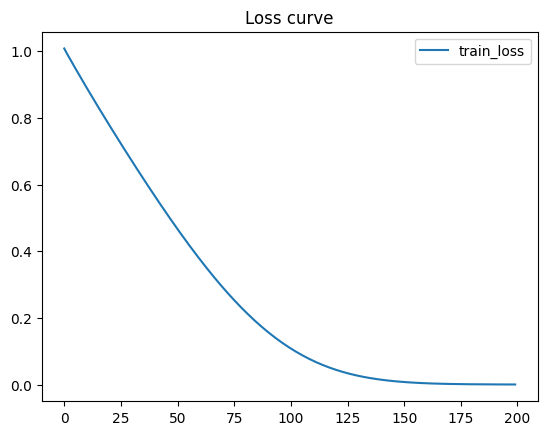

In [11]:
CKP_DIR_INIT = './weight/init/'
CKP_DIR = './weight'

# prepare datasets
dataset_train = tf.data.Dataset.from_tensor_slices(df_clicked)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

M_USERS = 6000

# build the model
model = FunkSVDRecommender(m_users=M_USERS, 
                           n_items=N_ITEMS,
                           bias_mu=BIAS_MU,
                           embedding_size=EMBEDDING_SIZE, 
                           learning_rate=LEARNING_RATE,
                           regularization_train=REGULARIZATION_TRAIN,
                           regularization_update=REGULARIZATION_UPDATE,
                           seed=SEED)

# train the model
train_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset_train, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    train_losses.append(avg_train_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')

    if epoch % 20 == 0:
        model.save_weights(os.path.join(CKP_DIR_INIT, f'ckpt-{epoch}'))
        
# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

In [12]:
def train_model(model, dataset_train, CKP_PATH):
    # train the model
    train_losses = []

    for epoch in range(1, N_EPOCHS + 1):
        train_loss = []
        print(f'Epoch {epoch}:')

        # training
        for data in tqdm(dataset_train, desc='Training'):
            loss = model.train_step(data)
            train_loss.append(loss.numpy())

        # record losses
        avg_train_loss = np.mean(train_loss)
        train_losses.append(avg_train_loss)

        # print losses
        print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')

        if epoch % 10 == 0:
            model.save_weights(os.path.join(CKP_PATH, f'ckpt_EPOCH_{epoch}'))

In [13]:
# Initialize the training environment
train_env = TrainingEnvironment()

# Reset the training environment (this can be useful when you have finished one episode of simulation and do not want to re-initialize a new environment)
train_env.reset()

# Check if there exist any active users in the environment
env_has_next_state = train_env.has_next_state()
print(f'There is {"still some" if env_has_next_state else "no"} active users in the training environment.')

# Get the current user ID
user_id = train_env.get_state()
print(f'The current user is user {user_id}.')

# Get the response of recommending the slate to the current user
model.load_weights('./weight/init/ckpt-200')
recommended_items = model.eval_predict_onestep(user_id)
slate = recommended_items

# slate = [0, 1, 2, 3, 4]

clicked_id, in_environment = train_env.get_response(slate)
print(f'The click result of recommending {slate} to user {user_id} is {f"item {clicked_id}" if clicked_id != -1 else f"{clicked_id} (no click)"}.')
print(f'User {user_id} {"is still in" if in_environment else "leaves"} the environment.')

# Get the normalized session length score of all users
train_score = train_env.get_score()
df_train_score = pd.DataFrame([[user_id, score] for user_id, score in enumerate(train_score)], columns=['user_id', 'avg_score'])
df_train_score

There is still some active users in the training environment.
The current user is user 692.
The click result of recommending [111036  73087  45046 137117 166618] to user 692 is -1 (no click).
User 692 is still in the environment.


,user_id,avg_score
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
995,995,0.0
996,996,0.0
997,997,0.0
998,998,0.0


## Testing

While testing, you are allowed to update your model. However, please adhere to the following rules:

1. Follow the testing template provided below. Modify only the sections marked as `[TODO]`. Additionally, please carefully follow the instructions specified in each `[TODO]` section. Modifying other sections or not adhering to the instructions is strictly forbidden.

2. Limit model updates to one testing episode. During testing-time updates, follow these steps: (a) **Load your model weights** trained exclusively on the training environment. (b) Run the testing environment and update your model with the collected data **during the testing process**. (c) Obtain the score for this testing episode and **delete your model weights since they now contain some testing information**. **You should not save the model weights trained on the testing environment for another testing episode. Doing so will be regarded as cheating.**

3. Due to the randomness in the user decision process, **run the testing process 5 times** and calculate the **average session length** for each user as the final score. This part has been covered for you.

After completing the testing process, remember to submit the generated `output.csv` file to the [Kaggle competition](https://www.kaggle.com/t/b06e248a3827434f80c4fdc6009d5fe0).

We will illustrate the testing process with a pure random recommender below.


In [ ]:
# Initialize the testing environment
test_env = TestingEnvironment()
scores = []

# The item_ids here is for the random recommender
item_ids = [i for i in range(N_ITEMS)]

# Create a new DataFrame to hold the appended data
df_clicked_new = df_clicked.copy()

# Create a Checkpoint object for the initial weights
initial_checkpoint = tf.train.Checkpoint(model=model)
initial_checkpoint.restore('./weight/init/ckpt-200')

# N = 2000

# Repeat the testing process for 5 times
for episode in range(1, TEST_EPISODES+1):
    # [TODO] Load your model weights here (in the beginning of each testing episode)
    # [TODO] Code for loading your model weights...
    initial_checkpoint.restore('./weight/init/ckpt-200')
    
    # Start the testing process
    with tqdm(desc='Testing') as pbar:
        # Run as long as there exist some active users
        while test_env.has_next_state():
            # Get the current user id
            cur_user = test_env.get_state()

            # [TODO] Employ your recommendation policy to generate a slate of 5 distinct items
            # [TODO] Code for generating the recommended slate...
            # Here we provide a simple random implementation
            # slate = random.sample(item_ids, k=SLATE_SIZE)
            recommended_items = model.eval_predict_onestep(cur_user)
            slate = recommended_items
            # Get the response of the slate from the environment
            clicked_id, in_environment = test_env.get_response(slate)
            
#             if in_environment == False:
#                 N -= 1
#            print(f'There are {N} users in the env now!')

            # [TODO] Update your model here (optional)
            # [TODO] You can update your model at each step, or perform a batched update after some interval
            # [TODO] Code for updating your model...
#             if in_environment == False:
#                 N -= 1
#             print(f'There are {N} active users in the env now!')
            
#             if clicked_id != -1:
#                 new_row = [cur_user, clicked_id, 1]
#                 df_clicked_new = pd.concat([df_clicked_new, pd.DataFrame([new_row], columns=df_clicked.columns)], ignore_index=True)
#             else:
#                 for i in slate:
#                     new_row = [cur_user, i.numpy().item(), 0]
#                     df_clicked_new = pd.concat([df_clicked_new, pd.DataFrame([new_row], columns=df_clicked.columns)], ignore_index=True)
            
#             dataset_clicked_new = tf.data.Dataset.from_tensor_slices(df_clicked_new)
#             dataset_clicked_new = dataset_clicked_new.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
            
#             CKP_PATH = f'./weight/episode_{episode}/'
            
#             train_model(model, dataset_clicked_new, CKP_PATH)
                
            # Update the progress indicator
            pbar.update(1)

    # Record the score of this testing episode
    scores.append(test_env.get_score())

    # Reset the testing environment
    test_env.reset()

    # [TODO] Delete or reset your model weights here (in the end of each testing episode)
    # [TODO] Code for deleting your model weights...
    model.set_weights(initial_checkpoint.model.get_weights())

# Calculate the average scores 
avg_scores = [np.average(score) for score in zip(*scores)]

# Generate a DataFrame to output the result in a .csv file
df_result = pd.DataFrame([[user_id, avg_score] for user_id, avg_score in enumerate(avg_scores)], columns=['user_id', 'avg_score'])
df_result.to_csv(OUTPUT_PATH, index=False)
df_result

Testing: 10078it [00:37, 266.30it/s]
Testing: 10096it [00:37, 266.26it/s]
Testing: 8426it [00:31, 264.74it/s]

## Scoring

- Ranking of **private** leaderboard of the Kaggle competition. (80%)
- Report. (20%)

### How is the Score For Ranking Calculated:

We will calculate the MAE (Mean Absolute Error) between your submitted `output.csv` and a "ground-truth" of all 1s. The lower the better.

### Your Report Should Contain:

- Models you have tried during the competition. Briefly describe the main idea of the model and the reason why you chose that model.
- List the experiments you have done. For instance, data collecting, utilizing the user / item datasets, hyperparameters tuning, training process, and so on.
- Discussions, lessons learned, or anything else worth mentioning.
- **Ensure your report notebook contains your training and testing code. We will re-run your code if we find your score on Kaggle suspicious.**

Please name your report as `DL_comp4_{Your Team name}_report.ipynb.` and submit your report to the eeclass system before the deadline.

## What You Can Do

- Implement any recommender models.
- Collect data through accessing the **public methods provided by the environments** (i.e. methods listed in the ***Environment Public Methods*** section) and train your model.
- Use the provided user history data (`dataset/user_data.json`) and item text description data (`dataset/item_data.json`) as auxiliary data to aid your model training.
- Update the model during one testing episode while **following the rules mentioned in the ***Testing*** section.**
- You can use a pretrained text encoder if you need text embeddings for the item text descriptions. **(This is the only part you can use a pretrained model in this competition.)**

## What You CAN NOT Do

- Use any dataset other than the provided ones. Using the original News Category Dataset is also prohibited.
- Use any pretrained recommender models.
- Plagiarize other teams' work.
- Hack our simulation environments. Any attempt of accessing or modifying the data files in the `evaluation` directory, modifying the source code of the environments, accessing or modifying the private attributes and methods (i.e. methods and attributes not listed in the ***Environment Public Methods*** section), not following the rules in the ***Testing*** section, or any other forbidden actions mentioned in the previous section of the notebook will be regarded as cheating.

## Competition Timeline

- 2024/01/08 (Mon): Competition launched.
- 2024/01/15 (Mon) 08:00 (TW): Competition deadline.
- 2024/01/16 (Tue) 12:00 (TW): Report deadline.
- 2024/01/16 (Tue) 15:30 (TW): Top-3 teams sharing.

## References

1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).